## Employee Attrition Prediction

As the COVID-19 keeps unleashing its havoc, the world continues to get pushed into the crisis of the great economic recession, more and more companies start to cut down their underperforming employees. Companies firing hundreds and thousands of Employees is a typical headline today. Cutting down employees or reducing an employee salary is a tough decision to take. Here in this project we look at various parameters responsible for attrition of employee and at the end will build a model to predict Employee Attrition.

In [145]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [146]:
X = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv")
X.head()

,Id,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
0,1,30,0,Non-Travel,Research & Development,2,3,Medical,571,3,...,3,0,12,2,11,7,6,7,4,1
1,2,36,0,Travel_Rarely,Research & Development,12,4,Life Sciences,1614,3,...,3,2,7,2,3,2,1,1,2,1
2,3,55,1,Travel_Rarely,Sales,2,1,Medical,842,3,...,3,0,12,3,9,7,7,3,5,1
3,4,39,0,Travel_Rarely,Research & Development,24,1,Life Sciences,2014,1,...,3,0,18,2,7,7,1,7,4,1
4,5,37,0,Travel_Rarely,Research & Development,3,3,Other,689,3,...,3,1,10,2,10,7,7,8,1,1


In [147]:
y = X['Attrition']
X.drop(['Attrition','Behaviour'], axis =1, inplace=True)
X_test.drop(['Behaviour'], axis =1, inplace=True)

In [148]:
X.shape

(1628, 27)

In [149]:
X_test.shape

(470, 27)

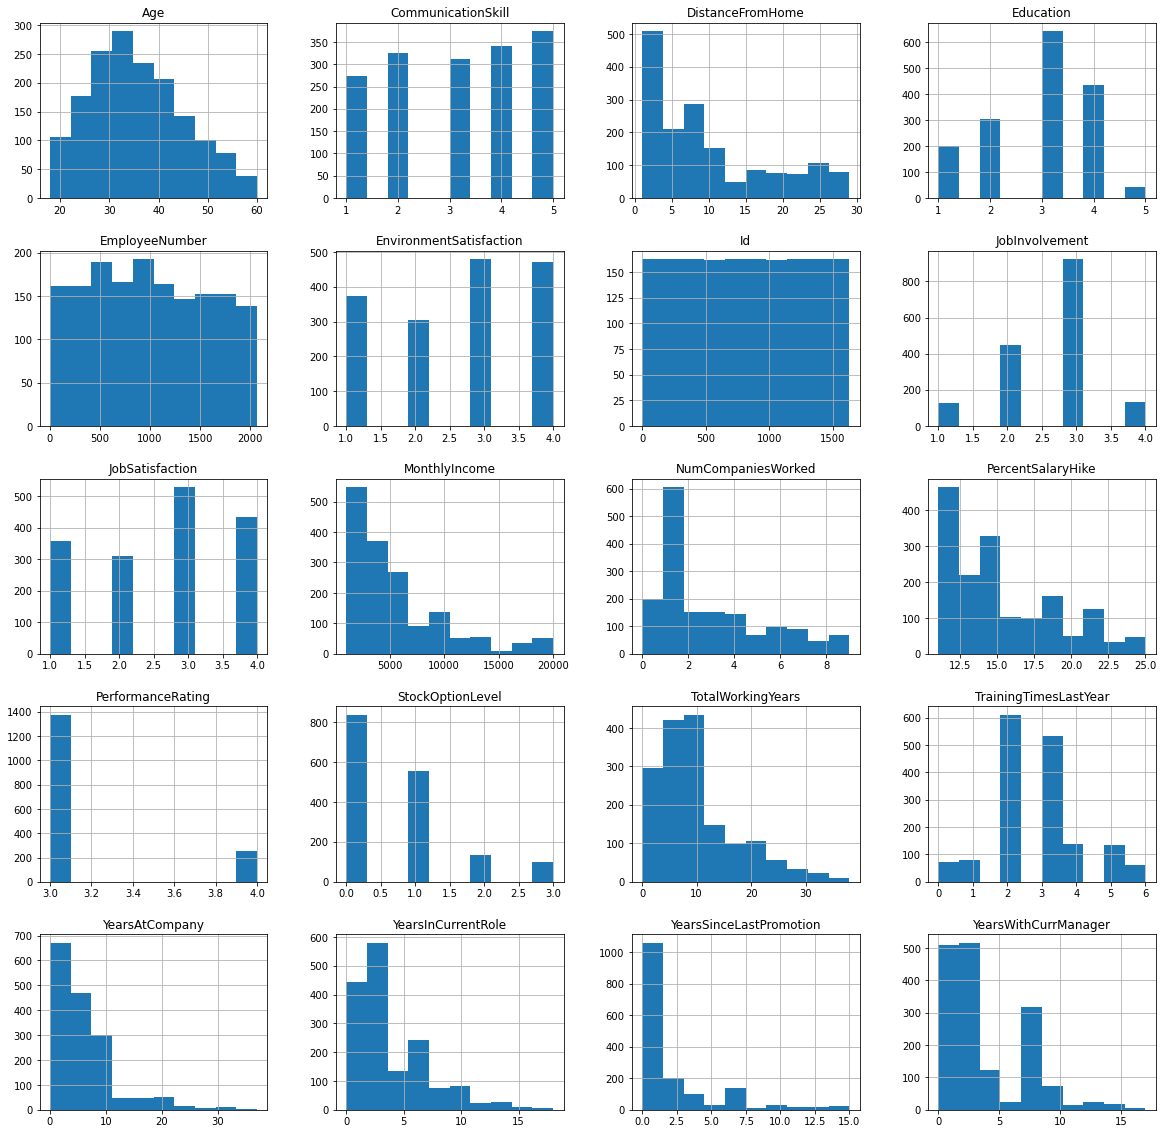

In [150]:
X.hist(figsize=(20,20))
plt.show()

### We can see some features are skewed

In [151]:
skew_col=[]
for col in X.columns:
    if(X[col].dtype!='object' and X[col].skew()>0.5):
        skew_col.append(col)
X[skew_col].skew()
#X.skew().sort_values(ascending=False)

DistanceFromHome           0.868562
MonthlyIncome              1.561333
NumCompaniesWorked         0.985959
PercentSalaryHike          0.831123
PerformanceRating          1.904065
StockOptionLevel           1.208191
TotalWorkingYears          1.169746
YearsAtCompany             1.943081
YearsInCurrentRole         1.115557
YearsSinceLastPromotion    2.071732
YearsWithCurrManager       1.015049
dtype: float64

In [152]:
X[skew_col]=np.sqrt(X[skew_col])
X_test[skew_col]=np.sqrt(X_test[skew_col])
X[skew_col].skew()

DistanceFromHome           0.318596
MonthlyIncome              0.992247
NumCompaniesWorked         0.058065
PercentSalaryHike          0.662171
PerformanceRating          1.904065
StockOptionLevel           0.366277
TotalWorkingYears          0.189665
YearsAtCompany             0.519996
YearsInCurrentRole        -0.070279
YearsSinceLastPromotion    0.808845
YearsWithCurrManager      -0.056409
dtype: float64

In [153]:
X['PercentSalaryHike']=np.log(X['PercentSalaryHike']) * 2
X_test['PercentSalaryHike']=np.log(X_test['PercentSalaryHike']) * 2
X['PercentSalaryHike'].skew()

0.49756207209896447

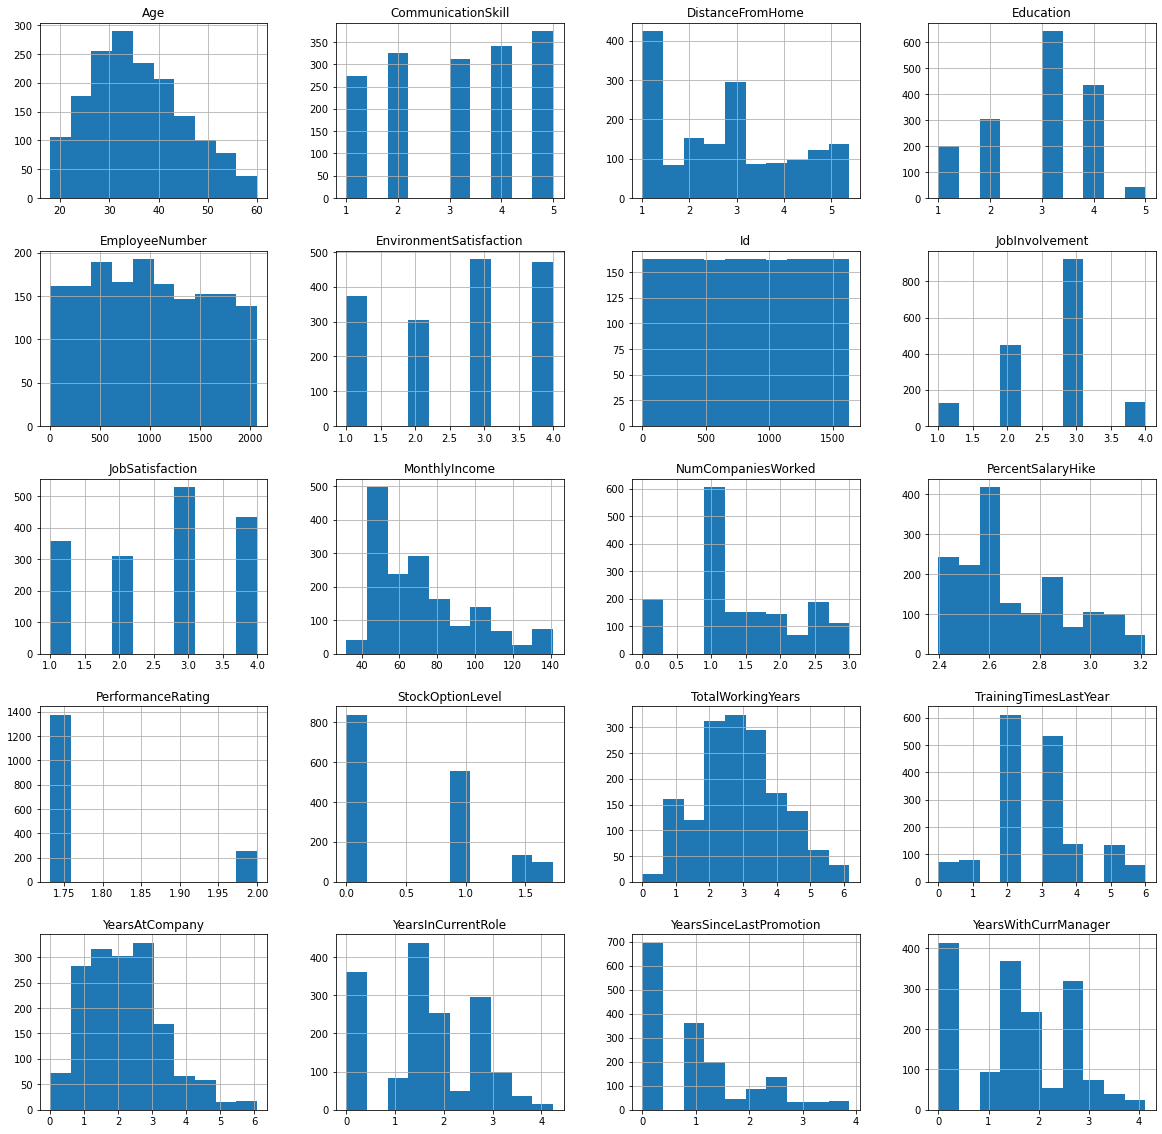

In [154]:
X.hist(figsize=(20,20))
plt.show()

In [155]:
obj_list=[obj_col for obj_col in X.select_dtypes(include='object')]
X[obj_list].nunique()

BusinessTravel    3
Department        3
EducationField    6
Gender            2
JobRole           9
MaritalStatus     3
OverTime          2
dtype: int64

### We have to encode Categorical data


In [156]:
from sklearn.preprocessing import LabelEncoder
X['BusinessTravel']=LabelEncoder().fit_transform(X['BusinessTravel'])
X_test['BusinessTravel']=LabelEncoder().fit_transform(X_test['BusinessTravel'])

In [157]:
from sklearn.preprocessing import OneHotEncoder
one_hot = list(set(obj_list)-set(['BusinessTravel']))
X = pd.concat([X, pd.DataFrame(OneHotEncoder().fit_transform(X[one_hot]).toarray())], axis=1)
X.drop(one_hot, axis=1, inplace=True)
X_test = pd.concat([X_test, pd.DataFrame(OneHotEncoder().fit_transform(X_test[one_hot]).toarray())], axis=1)
X_test.drop(one_hot, axis=1, inplace=True)

### Splitting train data for validation

In [158]:
from sklearn.model_selection import train_test_split
X.drop(columns='Id',inplace=True)
#X_test.drop(columns='Id',inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3,random_state=1)


### Models

In [159]:
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [160]:
num_iters=np.arange(200,501,50)
C = np.arange(0.1,3,0.1, dtype=np.float32)
arg=[]
for i in C:
    for j in num_iters: arg.append((j,i))

In [161]:
# model for checking the validation score
def model(arg):
    num_iters = arg[0]
    C=arg[1]
    lr=LogisticRegression(solver='liblinear', max_iter=num_iters,C=C, verbose=0, random_state=0)
    lr.fit(X_train,y_train)
    predictions = lr.predict(X_valid)
    return roc_auc_score(y_valid,predictions)

In [162]:
for params in arg:
    score = model(params)
    print("C={}, iterations={} : {}".format(params[1],params[0],score))

C=0.10000000149011612, iterations=200 : 0.7708772458094951
C=0.10000000149011612, iterations=250 : 0.7708772458094951
C=0.10000000149011612, iterations=300 : 0.7708772458094951
C=0.10000000149011612, iterations=350 : 0.7708772458094951
C=0.10000000149011612, iterations=400 : 0.7708772458094951
C=0.10000000149011612, iterations=450 : 0.7708772458094951
C=0.10000000149011612, iterations=500 : 0.7708772458094951
C=0.20000000298023224, iterations=200 : 0.7668122051590887
C=0.20000000298023224, iterations=250 : 0.7668122051590887
C=0.20000000298023224, iterations=300 : 0.7668122051590887
C=0.20000000298023224, iterations=350 : 0.7668122051590887
C=0.20000000298023224, iterations=400 : 0.7668122051590887
C=0.20000000298023224, iterations=450 : 0.7668122051590887
C=0.20000000298023224, iterations=500 : 0.7668122051590887
C=0.30000001192092896, iterations=200 : 0.7647294991468434
C=0.30000001192092896, iterations=250 : 0.7647294991468434
C=0.30000001192092896, iterations=300 : 0.76472949914684

C=2.200000047683716, iterations=350 : 0.7790826056408713
C=2.200000047683716, iterations=400 : 0.7790826056408713
C=2.200000047683716, iterations=450 : 0.7790826056408713
C=2.200000047683716, iterations=500 : 0.7790826056408713
C=2.299999952316284, iterations=200 : 0.7811402188095955
C=2.299999952316284, iterations=250 : 0.7811402188095955
C=2.299999952316284, iterations=300 : 0.7811402188095955
C=2.299999952316284, iterations=350 : 0.7811402188095955
C=2.299999952316284, iterations=400 : 0.7811402188095955
C=2.299999952316284, iterations=450 : 0.7811402188095955
C=2.299999952316284, iterations=500 : 0.7811402188095955
C=2.3999998569488525, iterations=200 : 0.7852805379905651
C=2.3999998569488525, iterations=250 : 0.7852805379905651
C=2.3999998569488525, iterations=300 : 0.7852805379905651
C=2.3999998569488525, iterations=350 : 0.7852805379905651
C=2.3999998569488525, iterations=400 : 0.7852805379905651
C=2.3999998569488525, iterations=450 : 0.7852805379905651
C=2.3999998569488525, ite

In [163]:
lr_final = LogisticRegression(solver='liblinear',C=2.3999998569488525, max_iter=300)
lr_final.fit(X_train,y_train)
y_pred = lr_final.predict(X_valid)
roc_auc_score(y_valid,y_pred)

0.7852805379905651

#### We will merge train and validation data and train model and predict y_test for submission

In [164]:
X_test

,Id,Age,BusinessTravel,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,MonthlyIncome,...,15,16,17,18,19,20,21,22,23,24
0,1,28,2,3.000000,3,377,4,3,4,45.497253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,31,2,2.449490,4,653,1,4,4,73.891813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,37,2,2.449490,3,474,3,4,1,77.291655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,42,2,1.000000,2,827,4,2,4,77.858847,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,45,0,2.000000,2,972,3,3,2,66.685831,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,466,32,2,1.414214,4,1692,4,3,2,37.322915,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
466,467,18,1,1.732051,2,1624,2,3,4,39.610605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
467,468,24,2,4.795832,3,639,2,4,4,52.201533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
468,469,31,2,4.795832,3,367,2,2,4,74.712783,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
X_train_final = pd.concat([X_train,X_valid],axis=0)
y_train_final = pd.concat([y_train,y_valid],axis=0)
X_train_final.reset_index(drop=True)
y_train_final.reset_index(drop=True)

0       0
1       1
2       1
3       1
4       1
       ..
1623    1
1624    1
1625    1
1626    0
1627    0
Name: Attrition, Length: 1628, dtype: int64

In [166]:
lr_final.fit(X_train_final,y_train_final)
lr_final

LogisticRegression(C=2.3999998569488525, max_iter=300, solver='liblinear')

### Output

In [169]:
final_pred = lr_final.predict_proba(X_test.drop(columns='Id'))[:,1]
output = pd.concat([X_test.Id,pd.Series(final_pred)], axis=1)
output.columns=['Id','Attrition']
output.set_index('Id')
output.to_csv("submission.csv",index=False)
final_pred

array([6.30572735e-02, 7.35883027e-02, 5.08427826e-01, 1.73110349e-01,
       5.06325016e-02, 2.54812822e-02, 3.56441896e-01, 5.88695103e-01,
       6.36495953e-01, 2.77877334e-02, 6.72277554e-03, 1.30379996e-01,
       3.13571993e-02, 8.38848055e-02, 8.24841719e-02, 3.05312025e-01,
       8.57708403e-01, 6.07968117e-01, 1.30084698e-01, 1.79007693e-02,
       8.79907975e-02, 9.51606104e-01, 1.70762797e-01, 9.94879471e-02,
       1.80768151e-01, 4.04455441e-02, 4.22114796e-02, 3.62744940e-02,
       8.78529095e-01, 1.33788405e-01, 6.62417679e-02, 5.31213160e-01,
       4.08027598e-01, 6.23115389e-01, 1.14089204e-02, 1.38436810e-01,
       1.79582593e-02, 3.49030907e-02, 7.57946810e-01, 5.33856225e-01,
       9.19800313e-01, 7.54054135e-01, 7.74403674e-03, 9.83227490e-02,
       6.67958418e-03, 3.18804920e-01, 9.22251267e-02, 8.03679027e-02,
       1.13372523e-02, 6.62180930e-01, 5.82119063e-01, 2.72787597e-01,
       6.29669557e-01, 7.77818268e-01, 7.05656067e-01, 4.66176270e-01,
      